<a href="https://colab.research.google.com/github/jayshah1819/CUDA-Accelerated-Chest-X-Ray-Classification-with-ONNX/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1918","key":"89b5046329f630e45ae6577ff9006564"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:34<00:00, 38.1MB/s]
100% 2.29G/2.29G [00:34<00:00, 71.5MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip -d ./dataset


Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-044

In [6]:
import os


dataset_path = "./dataset/chest_xray"


print(os.listdir(dataset_path))


for folder in ['train', 'test', 'val']:
    folder_path = os.path.join(dataset_path, folder)
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        num_images = len([f for f in os.listdir(class_path) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')])
        print(f"{folder}/{class_name}: {num_images} images")


['val', 'train', '__MACOSX', 'chest_xray', 'test']
train/PNEUMONIA: 3875 images
train/NORMAL: 1341 images
test/PNEUMONIA: 390 images
test/NORMAL: 234 images
val/PNEUMONIA: 8 images
val/NORMAL: 8 images


Using Numba.

In [8]:
!pip install opencv-python-headless
!pip install numba

In [9]:
import cv2
import numpy as np
from numba import cuda

same like c++






    # __global__ void rbgaToBC(const unsigned char* rbga, unsigned char* grey,int W,int H){
       int x= threadIdx.x+ blockDim.x* blockIdx.x;
       int y= threadIdx.y+ blockDim.y* blockIdx.y;

       //1d array where its we need it find it lets say its at x=5,y=5, width=20;
       //it would be 5*20+5;x*width+y;

       int idx=x*w+y;

       if(x<<w && y<<h){
            unsigned char r=rbga[4*idx+0];
            unsigned char g=rbga[4*idx+1];
            unsigned char b=rbga[4*idx+2];

            grey[idx]= static_cast<unsigned char>(0.299f * r + 0.587f * g + 0.114f * b);
       }

# }

In [10]:
@cuda.jit
def rgba_to_gray_normalized(rgba, gray):
    x, y = cuda.grid(2)
    h, w = gray.shape
    if x < w and y < h:
        r = rgba[y, x, 0]
        g = rgba[y, x, 1]
        b = rgba[y, x, 2]

        gray_val = 0.299*r + 0.587*g + 0.114*b
        gray[y, x] = gray_val / 255.0


In [11]:
def preprocess_image_gpu(image):
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)

    h, w, c = image.shape
    gray = np.zeros((h, w), dtype=np.float32)

    d_rgba = cuda.to_device(image)
    d_gray = cuda.to_device(gray)

    threadsperblock = (16, 16)
    blockspergrid_x = (w + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (h + threadsperblock[1] - 1) // threadsperblock[1]


    rgba_to_gray_normalized[(blockspergrid_x, blockspergrid_y), threadsperblock](d_rgba, d_gray)
    cuda.synchronize()


    d_gray.copy_to_host(gray)

    return gray


**The error will be **


Numba generates PTX code for your CUDA kernel.

The PTX version it generated is 8.5.

Colab’s current GPU driver only supports PTX version 8.4.

When Numba tries to load the kernel, the driver says: “Unsupported PTX version”, and the kernel fails.



we will change the version of numba cuda

In [20]:
!uv pip install -q --system numba-cuda==0.4.0

In [21]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [23]:
input_folder = "./dataset/chest_xray/train/NORMAL"
output_folder = "./dataset/chest_xray/train_preprocessed/NORMAL"
os.makedirs(output_folder, exist_ok=True)

image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpeg')]

for file in image_files:
    img = cv2.imread(os.path.join(input_folder, file))
    gray_img = preprocess_image_gpu(img)
    #normalized
    gray_save = (gray_img * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(output_folder, file), gray_save)


Resize the images to 416X416 (as our yolo v8 takes that size)

Batching

In [73]:
batch_img = np.load(os.path.join(output_folder, file))  # shape (1,1,H,W)
gray_img = batch_img[0, 0]  # get HxW

# replicate to 3 channels
img_3ch = np.stack([gray_img, gray_img, gray_img], axis=0)  # shape 3,H,W

# resize each channel to 224x224
resized_channels = [cv2.resize(img_3ch[c], (224, 224)) for c in range(3)]
batch_resized = np.expand_dims(np.stack(resized_channels, axis=0), axis=0).astype(np.float32)


In [70]:
np.save(os.path.join(output_folder, file.replace('.jpeg', '.npy')), batch_img)


Now export it to ONNX version

In [36]:
!pip install torchvision


In [37]:
import torch
import torchvision.models as models

model = models.densenet121(pretrained=True)


model.eval()

print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 134MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

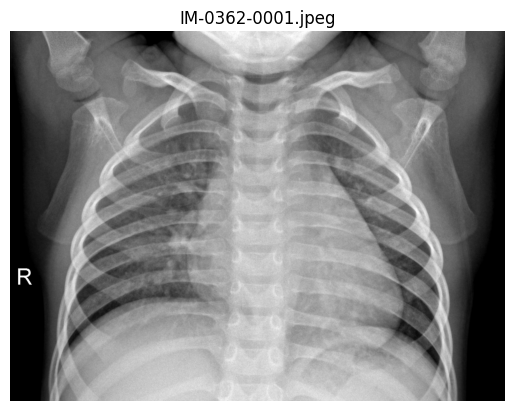

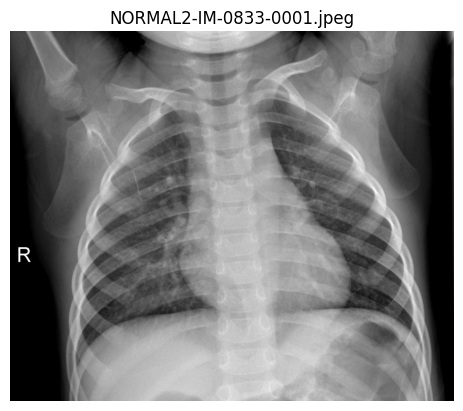

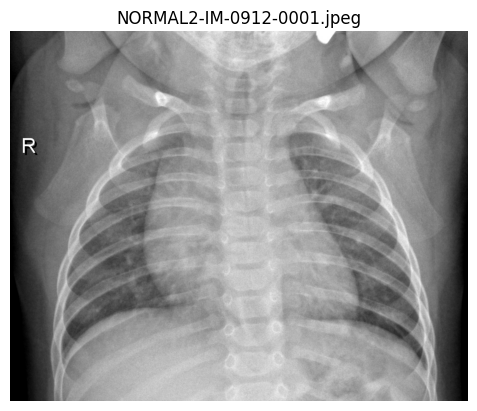

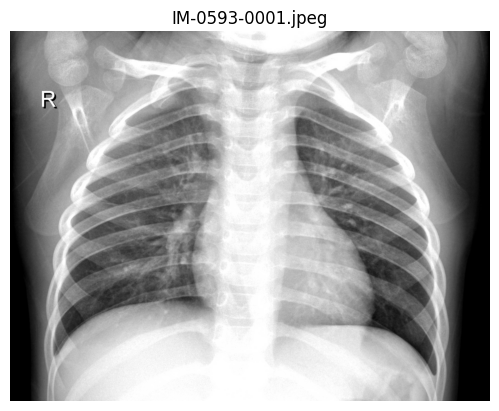

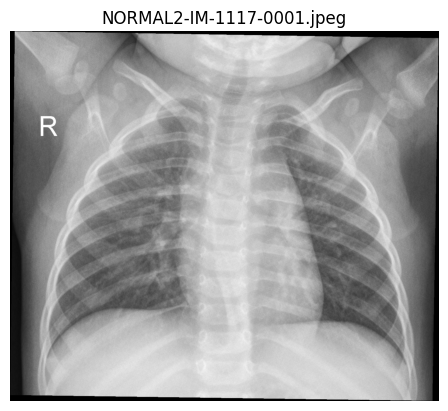

In [71]:
import matplotlib.pyplot as plt
import cv2
import os

output_folder = "./dataset/chest_xray/train_preprocessed/NORMAL"
files = os.listdir(output_folder)[:5]  # first 5 images

for file in files:
    img_path = os.path.join(output_folder, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # read as grayscale

    plt.imshow(img, cmap='gray')
    plt.title(file)
    plt.axis("off")
    plt.show()


In [66]:
model = models.densenet121(pretrained=True)
model.eval()

batch_tensor = torch.tensor(batch_np, dtype=torch.float32)

start = time.time()
with torch.no_grad():
    outputs = model(batch_tensor)
end = time.time()

torch_time = (end - start) * 1000  # ms
print(f"PyTorch inference time: {torch_time:.2f} ms for {batch_np.shape[0]} images")

PyTorch inference time: 5642.09 ms for 1 images


In [45]:
import torch
import torchvision.models as models
import numpy as np
import cv2
import os


for file in files:
    img_path = os.path.join(output_folder, file)

    # Already preprocessed grayscale image
    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape (H,W)

    # Expand to 3 channels
    img_3ch = np.stack([gray_img, gray_img, gray_img], axis=0)  # shape (3,H,W)

    # Add batch dimension
    batch_img = np.expand_dims(img_3ch, axis=0)  # shape (1,3,H,W)

    # Convert to float tensor
    batch_tensor = torch.tensor(batch_img, dtype=torch.float32)

    # Feed into model
    with torch.no_grad():
        outputs = model(batch_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        top_prob, top_class = torch.max(probabilities, dim=0)

    print(f"{file} → Predicted class index: {top_class.item()}, Confidence: {top_prob.item()*100:.2f}%")


IM-0362-0001.jpeg → Predicted class index: 783, Confidence: 84.05%
NORMAL2-IM-0833-0001.jpeg → Predicted class index: 783, Confidence: 79.24%
NORMAL2-IM-0912-0001.jpeg → Predicted class index: 783, Confidence: 95.53%
IM-0593-0001.jpeg → Predicted class index: 783, Confidence: 100.00%
NORMAL2-IM-1117-0001.jpeg → Predicted class index: 783, Confidence: 99.96%


In [49]:
import torch
import torchvision.models as models
import numpy as np

In [52]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 104.7 MB/s eta 0:00:00


In [53]:
import onnx

In [47]:
dummy_input = torch.randn(1, 3, 224, 224, dtype=torch.float32)

In [56]:


torch.onnx.export(
    model,
    dummy_input,
    "densenet121.onnx",
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Variable batch size
)



In [58]:
!pip install onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


In [75]:
import os
import numpy as np
import cv2
import onnxruntime as ort
import time
import pandas as pd

output_folder = "./dataset/chest_xray/train_preprocessed/NORMAL"
image_files = [f for f in os.listdir(output_folder) if f.endswith('.npy')]

# Load ONNX model
onnx_model_path = "densenet121.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

results = []

for file in image_files[:5]:  # test first 5 images
    # Load grayscale preprocessed image (1,1,H,W)
    batch_img = np.load(os.path.join(output_folder, file))

    # Extract HxW
    gray_img = batch_img[0, 0]

    # Replicate channels to get 3,H,W
    img_3ch = np.stack([gray_img, gray_img, gray_img], axis=0)

    # Resize each channel to 224x224
    resized_channels = [cv2.resize(img_3ch[c], (224, 224)) for c in range(3)]
    batch_resized = np.expand_dims(np.stack(resized_channels, axis=0), axis=0).astype(np.float32)  # (1,3,224,224)

    # ONNX inference & timing
    start = time.time()
    outputs = ort_session.run(None, {ort_session.get_inputs()[0].name: batch_resized})
    end = time.time()

    # Softmax to get probabilities
    probs = np.exp(outputs[0]) / np.sum(np.exp(outputs[0]), axis=1, keepdims=True)
    top_class = np.argmax(probs)
    top_prob = probs[0][top_class]

    results.append({
        "Image": file,
        "Predicted Class": int(top_class),
        "Confidence": float(top_prob),
        "Inference Time (ms)": (end - start) * 1000
    })

# Convert to DataFrame
df = pd.DataFrame(results)
print(df)


                      Image  Predicted Class  Confidence  Inference Time (ms)
0  NORMAL2-IM-1117-0001.npy              619    0.951666            86.623907
1          IM-0274-0001.npy              725    0.254658           103.681326


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


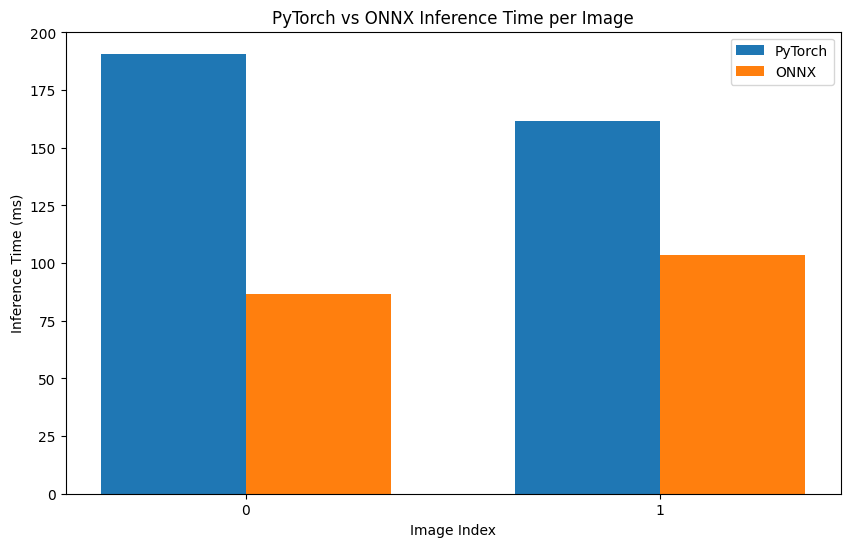

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import time

# Suppose batch_resized_images is the same batch you used for ONNX
# Stack all images for PyTorch inference
batch_tensor = torch.tensor(np.concatenate([batch_resized for file in image_files[:5]], axis=0), dtype=torch.float32)

# PyTorch inference
model = models.densenet121(pretrained=True)
model.eval()

torch_times = []
with torch.no_grad():
    for i in range(batch_tensor.shape[0]):
        img = batch_tensor[i:i+1]
        start = time.time()
        _ = model(img)
        end = time.time()
        torch_times.append((end - start) * 1000)  # ms per image

# ONNX inference times (from previous results)
onnx_times = df['Inference Time (ms)'].tolist()

# Plot bar chart
x = np.arange(len(torch_times))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, torch_times, width, label='PyTorch')
plt.bar(x + width/2, onnx_times, width, label='ONNX')
plt.xlabel("Image Index")
plt.ylabel("Inference Time (ms)")
plt.title("PyTorch vs ONNX Inference Time per Image")
plt.xticks(x)
plt.legend()
plt.show()
